# tutorial 1: scikit-multichannel basics

This tutorial shows you how to:
* build classifiers and regressors using the **MultichannelPipeline** class
* use voting to combine information from multiple pipeline channels
* visualize multichannel pipeline architectures
* estimate pipeline accuracy using **cross_val_score**
* use multichannel pipelines to make predictions
* save & load models
* mix and match algorithms in a single pipeline layer
* concatenate channels into a single vector to combine information from multiple pipeline channels
* use parallel processing to speed up pipeline fitting

## build pipelines with layering and broadcasting

The following cell contains code for building a fully functional channel ensemble classifier that takes 10 feature matrix inputs, trains a model on each input, and makes a prediction using soft voting.

In [1]:
from sklearn.ensemble import GradientBoostingClassifier
import skmultichannel as sm

clf = sm.MultichannelPipeline(n_channels=10)
base_clf = sm.make_transformer(GradientBoostingClassifier())
clf.add_layer(base_clf)
clf.add_layer(sm.SoftVotingClassifier())

,layer_0,layer_1
channel,,
0,{GradientBoostingClassifier}tr,SoftVotingClassifier
1,{GradientBoostingClassifier}tr,▽
2,{GradientBoostingClassifier}tr,▽
3,{GradientBoostingClassifier}tr,▽
4,{GradientBoostingClassifier}tr,▽
5,{GradientBoostingClassifier}tr,▽
6,{GradientBoostingClassifier}tr,▽
7,{GradientBoostingClassifier}tr,▽
8,{GradientBoostingClassifier}tr,▽


**Explanation**

* In line 5, the GradientBoostingClassifier is converted into a transformer using the the **make_transformer** function.  All pipeline compoments except those in the last layer must have transform methods that produce feature matrices for the next stage.


* In line 6, a single GradientBoostingClassifier intance is added to a pipeline with 10 channels.  The result is that GradientBoostingClassifier is broadcast (repeated) automatically to create one model per channel.  You can also make a list of 10 instances manually and use that to create the layer:   
    ``clf.add_layer([base_clf for i in range(10)])``    


* The **SoftVotingClassifier** object added in line 7 averages the prediction probabilites from the previous pipeline stage and outputs a single prediction.  SoftVotingClassifier is an example of a Multichannel pipeline component.  You can add either single channel pipeline components (standard scikit-learn algorithms) or multichannel components to a MultichannelPipeline.  A single SoftVotingClassifier was added to the 10 channel pipeline.  Because it it a multichannel component, skmultichannel maps all 10 inputs to the component rather than copying it 10 times.  


* Pipelines are displayed as pandas DataFrames when the pipeline name is on the last line of a Jupyter Notebook Cell.  


* The DataFrame display shows input channel indices on the left and layer channel indices on the top.  These indices can be used to reference specific pipeline components.  


* Notice that GradientBoostingClassifier is displayed in brackets with a trailing "tr."  This indicates that the classifier has been wrapped to provide transformer functionality.  


* The inverted triangles under SoftVotingClassifier indicate that the inputs of this component span multiple channels.  


* Multichannel transformers can output multiple matrices, but multichannel predictors always produce a single output (bc it would be unclear how to interpret multiple predictions).    


* Currently, multichannel components only accept contiguous blocks of input channels and each output channel maps to at most one component input.

## evaluate pipeline performance

In [2]:
Xs, y, matrix_types = sm.make_multi_input_classification(
    n_informative_Xs=5, n_random_Xs=5, n_weak_Xs=0)
accuracies = sm.cross_val_score(clf, Xs, y, cv=3)
print('Balanced accuracies for the 3 cross validation splits are: {}'.format(accuracies))

Balanced accuracies for the 3 cross validation splits are: [0.9705882352941176, 0.9375, 0.96875]


**notes**

* Scikit-multichannel provides synthetic data generators that make classification or regression datasets with multiple independent feature matrices with different quality levels (informative, weak, or random).  


* Scikit-multichannel provides **cross_val_score** and **cross_val_predict** functions similar to those of scikit-learn, but the skmultichannel versions take both multichannel and single channel predictors.  


* By default, skmultichannel's **cross_val_score** detects the type of predictor and uses balanced_accuracy_score for classifiers and explained_variance_score for regressors.  You can set the scorer parameter to provide a custom metric.

## model fitting

In [3]:
clf.fit(Xs, y)

,layer_0,out_0,layer_1,out_1
channel,,,,
0,{GradientBoostingClassifier}tr,→,SoftVotingClassifier,→
1,{GradientBoostingClassifier}tr,→,▽,
2,{GradientBoostingClassifier}tr,→,▽,
3,{GradientBoostingClassifier}tr,→,▽,
4,{GradientBoostingClassifier}tr,→,▽,
5,{GradientBoostingClassifier}tr,→,▽,
6,{GradientBoostingClassifier}tr,→,▽,
7,{GradientBoostingClassifier}tr,→,▽,
8,{GradientBoostingClassifier}tr,→,▽,


**notes**

* After model fitting, the display DataFrame now shows layer outputs as arrows.  This is useful for visualizing information flow when channel selectors inactivate some channels or when concatenators or predictors divert channel information.

## save and load the pipeline

In [4]:
clf.save('/tmp/pipeline_1.pkl')
clf2 = clf.load('/tmp/pipeline_1.pkl')
y_pred = clf2.predict(Xs)
for i in range(10):
    print('y_pred = {}, y_true = {}'.format(y_pred[i], y[i]))

y_pred = 0, y_true = 0
y_pred = 1, y_true = 1
y_pred = 0, y_true = 0
y_pred = 0, y_true = 0
y_pred = 1, y_true = 1
y_pred = 0, y_true = 0
y_pred = 0, y_true = 0
y_pred = 1, y_true = 1
y_pred = 1, y_true = 1
y_pred = 0, y_true = 0


In [5]:
Xs, y, matrix_types = sm.make_multi_input_classification(
    n_informative_Xs=10, n_random_Xs=0, n_weak_Xs=0)
accuracies = sm.cross_val_score(clf, Xs, y, cv=3)
print('Balanced accuracies for the 3 cross validation splits are: {}'.format(accuracies))

Balanced accuracies for the 3 cross validation splits are: [1.0, 1.0, 1.0]


## regression

In [6]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
import skmultichannel as sm

clf = sm.MultichannelPipeline(n_channels=5)
base_clf = sm.make_transformer(GradientBoostingRegressor())
clf.add_layer(base_clf)
clf.add_layer(sm.AggregatingRegressor(np.median))

,layer_0,layer_1
channel,,
0,{GradientBoostingRegressor}tr,AggregatingRegressor
1,{GradientBoostingRegressor}tr,▽
2,{GradientBoostingRegressor}tr,▽
3,{GradientBoostingRegressor}tr,▽
4,{GradientBoostingRegressor}tr,▽


## evaluate pipeline performance

In [7]:
Xs, y, matrix_types = sm.make_multi_input_regression(n_informative_Xs=5)
accuracies = sm.cross_val_score(clf, Xs, y, cv=3)
print('Explained variance scores for the 3 cross validation splits are: \n{}'.format(accuracies))

Explained variance scores for the 3 cross validation splits are: 
[0.23593700768610582, 0.16720179357498088, 0.15959766552485166]


**notes**

* The **AggregatingRegressor** component allows you to chose an aggregation fuction to convert an ensemble of regression predictions into a single prediction.  In this example np.median is used as an aggregator.

## component lists and channel mappings

When we don't want to simply broadcast a single algorithm across multiple channels but need fine control over pipeline components, skmultichannel provides two options: **component lists** and **channel mappings**.  Component list parameters specify one pipe per channel, and channnel mapping parameters specify enumerated blocks of channels.

The first example in this section illustrates the use of component lists, and the second illustrates the use of channel mappings.

In [8]:
# component lists
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import skmultichannel as sm

clf = sm.MultichannelPipeline(n_channels=10)
clf_A = sm.make_transformer(GradientBoostingClassifier()) 
clf_B = sm.make_transformer(LogisticRegression()) 
clf.add_layer([clf_A for i in range(5)] + [clf_B for i in range(5)])
clf.add_layer(sm.SoftVotingClassifier())

,layer_0,layer_1
channel,,
0,{GradientBoostingClassifier}tr,SoftVotingClassifier
1,{GradientBoostingClassifier}tr,▽
2,{GradientBoostingClassifier}tr,▽
3,{GradientBoostingClassifier}tr,▽
4,{GradientBoostingClassifier}tr,▽
5,{LogisticRegression}tr,▽
6,{LogisticRegression}tr,▽
7,{LogisticRegression}tr,▽
8,{LogisticRegression}tr,▽


**notes**

* GradientBoostingClassifier models have been added to the first five channels and LogisticRegression models to the last five.

In [9]:
# channel mappings
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import skmultichannel as sm

clf = sm.MultichannelPipeline(n_channels=10)
clf_A = sm.make_transformer(GradientBoostingClassifier()) 
clf_B = sm.make_transformer(LogisticRegression()) 
clf.add_layer(5, clf_A, 5, clf_B)
clf.add_layer(sm.SoftVotingClassifier())

,layer_0,layer_1
channel,,
0,{GradientBoostingClassifier}tr,SoftVotingClassifier
1,{GradientBoostingClassifier}tr,▽
2,{GradientBoostingClassifier}tr,▽
3,{GradientBoostingClassifier}tr,▽
4,{GradientBoostingClassifier}tr,▽
5,{LogisticRegression}tr,▽
6,{LogisticRegression}tr,▽
7,{LogisticRegression}tr,▽
8,{LogisticRegression}tr,▽


**notes**

* Line 9 shows channel mapping syntax: (5, clf_A, 5, clf_B) means 5 channels mapped to clf_A and the next 5 channels mapped to clf_B.  


* GradientBoostingClassifiers have been mapped to the first five channels and LogisticRegression models to the last five.  


* GradientBoostingClassifiers and LogisticRegression are automatically broadcast (repeated) across the 5 channel blocks to which they are mapped.

## concatenate channels 

### ChannelConcatenator

In this example, the 10 best features are selected from each input channel then concatenated together and used as features for GradientBoostingClassifier.  

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif
import skmultichannel as sm

Xs, y, matrix_types = sm.make_multi_input_classification(
    n_informative_Xs=10, n_random_Xs=0, n_weak_Xs=0)

clf = sm.MultichannelPipeline(n_channels=10)
clf.add_layer(StandardScaler())
clf.add_layer(SelectKBest(score_func=f_classif, k=10))
clf.add_layer(sm.ChannelConcatenator())
clf.add_layer(1, GradientBoostingClassifier())
clf.fit(Xs, y)
clf

,layer_0,out_0,layer_1,out_1,layer_2,out_2,layer_3,out_3
channel,,,,,,,,
0,StandardScaler,→,SelectKBest,→,ChannelConcatenator,→,GradientBoostingClassifier,→
1,StandardScaler,→,SelectKBest,→,▽,,,
2,StandardScaler,→,SelectKBest,→,▽,,,
3,StandardScaler,→,SelectKBest,→,▽,,,
4,StandardScaler,→,SelectKBest,→,▽,,,
5,StandardScaler,→,SelectKBest,→,▽,,,
6,StandardScaler,→,SelectKBest,→,▽,,,
7,StandardScaler,→,SelectKBest,→,▽,,,
8,StandardScaler,→,SelectKBest,→,▽,,,


**notes**

* ChannelConcatenator concatenates the 10 vectors from the different channels and outputs them into the first available channel (in this case channel 0).  

### MultichannelPredictor

In this example, the 10 best features are selected from each input channel then concatenated together and used as features for GradientBoostingClassifier.  

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif
import skmultichannel as sm

Xs, y, matrix_types = sm.make_multi_input_classification(
    n_informative_Xs=10, n_random_Xs=0, n_weak_Xs=0)

clf = sm.MultichannelPipeline(n_channels=10)
clf.add_layer(StandardScaler())
clf.add_layer(SelectKBest(score_func=f_classif, k=10))
clf.add_layer(sm.MultichannelPredictor(GradientBoostingClassifier()))
clf.fit(Xs, y)
clf

,layer_0,out_0,layer_1,out_1,layer_2,out_2
channel,,,,,,
0,StandardScaler,→,SelectKBest,→,GradientBoostingClassifier_MC,→
1,StandardScaler,→,SelectKBest,→,▽,
2,StandardScaler,→,SelectKBest,→,▽,
3,StandardScaler,→,SelectKBest,→,▽,
4,StandardScaler,→,SelectKBest,→,▽,
5,StandardScaler,→,SelectKBest,→,▽,
6,StandardScaler,→,SelectKBest,→,▽,
7,StandardScaler,→,SelectKBest,→,▽,
8,StandardScaler,→,SelectKBest,→,▽,


**notes**

* **MultiChannelPredictor** concatenates the 10 vectors outputs from layer 1 into a single vector and uses it as input for GradientBoostingClassifier.  In effect, this class wraps a single channel predictor to make a multichannel predictor. 


* The _MC suffix indicates that a predictor has been wrapped to provide MultiChannel capabilities.

## parallel processing

Scikit-multichannel can train models in parallel if you set the **pipe_processes** parameter when building the pipeline.  You can specify the number of CPUs to use or 'max' to use all available CPUs.  Most skmultichannel classes have built in parallel processing that can be set with a parameter like pipe_processes, cv_processes, or n_processes.  In this example, the computationally expensive GradientBoostingClassifier algorithm is run in up to 10 parallel jobs, one for each channel.

In [12]:
import time
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import skmultichannel as sm
import skmultichannel.parallel as parallel

parallel.start_if_needed()

Xs, y, matrix_types = sm.make_multi_input_classification(
    n_informative_Xs=10, n_random_Xs=0, n_weak_Xs=0)

clf = sm.MultichannelPipeline(n_channels=10)
clf_A = sm.make_transformer(GradientBoostingClassifier()) 
clf.add_layer(clf_A, pipe_processes='max')
clf.add_layer(sm.SoftVotingClassifier())

t = time.time()
accuracies = sm.cross_val_score(clf, Xs, y, cv=3)
t_parallel = time.time() - t
clf

2022-12-03 15:27:48,487	INFO services.py:1456 -- View the Ray dashboard at http://127.0.0.1:8265


,layer_0,layer_1
channel,,
0,{GradientBoostingClassifier}tr,SoftVotingClassifier
1,{GradientBoostingClassifier}tr,▽
2,{GradientBoostingClassifier}tr,▽
3,{GradientBoostingClassifier}tr,▽
4,{GradientBoostingClassifier}tr,▽
5,{GradientBoostingClassifier}tr,▽
6,{GradientBoostingClassifier}tr,▽
7,{GradientBoostingClassifier}tr,▽
8,{GradientBoostingClassifier}tr,▽


/tmp/ipykernel_306700/4017233652.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(xlabels, rotation=45, ha='right', fontsize=12)


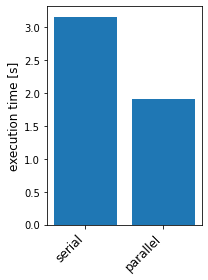

In [13]:
clf = sm.MultichannelPipeline(n_channels=10)
clf_A = sm.make_transformer(GradientBoostingClassifier()) 
clf.add_layer(clf_A, pipe_processes=1)
clf.add_layer(sm.SoftVotingClassifier())

t = time.time()
accuracies = sm.cross_val_score(clf, Xs, y, cv=3)
t_serial = time.time() - t

%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 1)
fig.set_size_inches(3, 4)
xlabels = ['serial', 'parallel']
axes.bar(xlabels, [t_serial, t_parallel])
axes.set_ylabel('execution time [s]', fontsize=12)
axes.set_xticklabels(xlabels, rotation=45, ha='right', fontsize=12)
plt.tight_layout()